Fetching Historical Data

In [19]:
import yfinance as yf
import pandas as pd
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Define stock symbols and date range
start_date = "2015-01-01"
end_date = "2024-12-01"
adbe_symbol = "ADBE"
msft_symbol = "MSFT"

# Fetch historical data
adbe_data = yf.download(adbe_symbol, start=start_date, end=end_date)
msft_data = yf.download(msft_symbol, start=start_date, end=end_date)

# Focus on closing prices
prices = pd.DataFrame({
    "ADBE": adbe_data["Close"],
    "MSFT": msft_data["Close"]
}).dropna()

print(prices.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                 ADBE       MSFT
Date                            
2015-01-02  72.339996  46.759998
2015-01-05  71.980003  46.330002
2015-01-06  70.529999  45.650002
2015-01-07  71.110001  46.230000
2015-01-08  72.919998  47.590000


Apply Kalman Filter

In [20]:
from pykalman import KalmanFilter
import numpy as np

# Set up Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

# Estimate dynamic relationship between ADBE and MSFT
state_means, _ = kf.filter(prices['MSFT'] / prices['ADBE'])

# Extract alpha and beta
alpha = state_means[:-1]  # Exclude last point for alignment
beta = prices['MSFT'][:-1] / prices['ADBE'][:-1]

# Add alpha and beta to the DataFrame
prices['Alpha'] = np.nan
prices['Beta'] = np.nan
prices.iloc[:-1, prices.columns.get_loc('Alpha')] = alpha
prices.iloc[:-1, prices.columns.get_loc('Beta')] = beta

print(prices.tail())


                  ADBE        MSFT     Alpha      Beta
Date                                                  
2024-11-22  512.150024  417.000000  0.831768  0.814215
2024-11-25  518.729980  418.790009  0.829444  0.807337
2024-11-26  525.299988  427.989990  0.828046  0.814753
2024-11-27  513.679993  422.989990  0.827609  0.823450
2024-11-29  515.929993  423.459991       NaN       NaN


Generate Trading Signal

In [21]:
# Calculate spread
prices['Spread'] = prices['MSFT'] - (prices['Alpha'] + prices['Beta'] * prices['ADBE'])

# Calculate rolling mean and standard deviation
rolling_mean = prices['Spread'].rolling(window=20).mean()
rolling_std = prices['Spread'].rolling(window=20).std()

# Define trading signals
prices['Buy Signal'] = prices['Spread'] < (rolling_mean - 2 * rolling_std)
prices['Sell Signal'] = prices['Spread'] > (rolling_mean + 2 * rolling_std)

print(prices[['Spread', 'Buy Signal', 'Sell Signal']].tail())


              Spread  Buy Signal  Sell Signal
Date                                         
2024-11-22 -0.831768       False        False
2024-11-25 -0.829444       False        False
2024-11-26 -0.828046       False        False
2024-11-27 -0.827609       False        False
2024-11-29       NaN       False        False


Backtesting

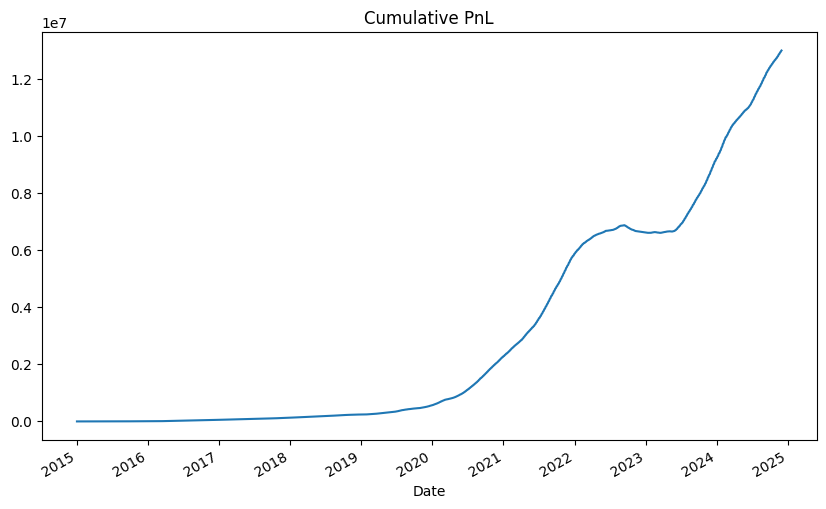

In [22]:
# Initialize variables for backtesting
cash = 0
position = 0
transaction_cost = 0.001  # 0.1% per trade

# Calculate PnL
prices['PnL'] = 0
for i in range(len(prices)):
    if prices['Buy Signal'][i]:
        position += 1
        cash -= prices['ADBE'][i] * (1 + transaction_cost)
    elif prices['Sell Signal'][i] and position > 0:
        position -= 1
        cash += prices['ADBE'][i] * (1 - transaction_cost)
    prices['PnL'][i] = cash + position * prices['ADBE'][i]

# Plot cumulative PnL
import matplotlib.pyplot as plt

prices['Cumulative PnL'] = prices['PnL'].cumsum()
prices['Cumulative PnL'].plot(figsize=(10, 6), title="Cumulative PnL")
plt.show()